# Make Pass Network

In [3]:
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import json

In [7]:
lineups_path = '/work/friendsof/assets/open-data-master/data/lineups/'
events_path = '/work/friendsof/assets/open-data-master/data/events/'
team_name = "Argentina"
match_id = 7580
file_name = str(match_id)+'.json'

with open(lineups_path+file_name) as file:
    lineups = json.load(file)
# lineups

In [8]:
with open(lineups_path+file_name)as file:
    source = json.load(file)
# source[1]

In [9]:
names_dict = {
    player['player_name']:player['player_nickname'] for team in source for player in team['lineup']
}

In [10]:
with open(events_path+file_name)as file:
    source = json.load(file)
# source

In [11]:
df_events = json_normalize(source, sep='_').assign(match_id=match_id)
df_events.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,pass_shot_assist,goalkeeper_body_part_id,goalkeeper_body_part_name,50_50_outcome_id,50_50_outcome_name,ball_recovery_offensive,goalkeeper_technique_id,goalkeeper_technique_name,shot_one_on_one,match_id
0,b655c0a4-d309-4bd9-8f03-e713363a73b4,1,1,00:00:00.000,0,0,1,0.00,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7580
1,39b8bd67-44ec-41fb-87d6-ce26efc2d691,2,1,00:00:00.000,0,0,1,0.00,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7580
2,0433dac7-c72f-4409-9240-abbb6d620525,3,1,00:00:00.000,0,0,1,0.00,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7580
3,fe850519-7056-4cdf-949e-a2513b2ccc6b,4,1,00:00:00.000,0,0,1,0.00,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7580
4,297180ed-6ff2-4e49-8ff8-510ff6882abe,5,1,00:00:01.880,0,1,2,2.04,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7580


In [12]:
first_red_card_minute = df_events[df_events['foul_committed_card_name'].isin(['Second Yellow', 'Red Card'])]['minute'].min()

first_substitution_minute = df_events[df_events['type_name']=='Substitution']['minute'].min()

max_minute = df_events['minute'].max()

num_minutes = min(first_substitution_minute, first_red_card_minute, max_minute)

plot_name = f'statsbomb_match{match_id}_{team_name}'
opponent_team = [team for team in df_events['team_name'].unique() if team != team_name][0]
plot_title = f"{team_name}'s Pass Network against {opponent_team}"
plot_legend = 'Location:pass origin\nSize:number of passes\nColor:num bar of passes'

In [13]:
names_dict = {
    player['player_name']:player['player_nickname']
            for team in lineups for player in team['lineup']
}
# names_dict

with open(events_path+file_name)as file:
    events = json.load(file)
# events

df_events = json_normalize(events,sep='_').assign(match_id=match_id)

first_red_card_minute = df_events[df_events['foul_committed_card_name'].isin(["Second Yellow", "Red Card"])]['minute'].min()

first_substitution_minute = df_events[df_events['type_name']=='Substitution']['minute'].min()

max_minute = df_events['minute'].max()

num_minutes = min(first_substitution_minute, first_red_card_minute, max_minute)

plot_name = 'statsbomb_match{0}_{1}'.format(match_id, team_name)

opponent_team = [x for x in df_events['team_name'].unique() if x != team_name][0]

plot_title = "{0}'s passing network against {1} (StatsBomb eventing data)'".format(team_name, opponent_team)

plot_legend = 'Location:pass origin\nSize:number of passes\nColor:num bar of passes'
num_minutes

45

In [97]:
def _statsbomb_to_point(location, max_width=120, max_height=80):
    '''
    Convert a point's coordinates from a StatsBomb's range to 0-1 range.
    '''
    return location[0]/max_width,1-(location[1]/max_height)

In [106]:
df_passes = df_events[
    (df_events['type_name']=='Pass')&
    (df_events['pass_outcome_name'].isna())&
    (df_events['team_name']==team_name)&
    (df_events['minute'] < num_minutes)
].copy()
df_passes['pass_recipient_name'] = df_passes['pass_recipient_name'].apply(lambda x:names_dict[x] if names_dict[x] else x)
df_passes['player_name'] = df_passes['player_name'].apply(lambda x:names_dict[x] if names_dict[x] else x)

df_passes[['player_name', 'pass_recipient_name']]

,player_name,pass_recipient_name
50,Marcos Rojo,Nicolás Tagliafico
53,Nicolás Tagliafico,Marcos Rojo
56,Marcos Rojo,Nicolás Otamendi
59,Nicolás Otamendi,Gabriel Mercado
62,Gabriel Mercado,Cristian Pavón
...,...,...
1768,Éver Banega,Nicolás Otamendi
1771,Nicolás Otamendi,Gabriel Mercado
1774,Gabriel Mercado,Lionel Messi
1779,Lionel Messi,Javier Mascherano


In [111]:
df_passes['origin_pos_x'] = df_passes['location'].apply(lambda x: _statsbomb_to_point(x)[0])
df_passes['origin_pos_y'] = df_passes['location'].apply(lambda x: _statsbomb_to_point(x)[1])
player_position = df_passes.groupby('player_name').agg({'origin_pos_x':'median','origin_pos_y':'median'})


player_pass_count = df_passes.groupby('player_name').size().to_frame('num_passes')
player_pass_value = df_passes.groupby('player_name').size().to_frame('pass_value')

In [132]:
player_pass_count = df_passes.groupby('player_name').size().to_frame('num_passes')
player_pass_value = df_passes.groupby("player_name").size().to_frame("pass_value")

df_passes['pair_key'] = df_passes.apply(lambda x:'_'.join(sorted([x['player_name'], x['pass_recipient_name']])), axis=1)
pair_pass_count = df_passes.groupby('pair_key').size().to_frame('num_passes')
pair_pass_count = df_passes.groupby('pair_key').size().to_frame('pass_value')




In [129]:
df_passes['pair_key'] = df_passes.apply(lambda x:'_'.join(sorted([x['player_name'],x['pass_recipient_name']])), axis=1)
pair_pass_count = df_passes.groupby('pair_key').size().to_frame('num_passes')
pair_pass_value = df_passes.groupby('pair_key').size().to_frame('pass_value')

In [133]:
import matplotlib.pyplot as plt
from visualization.passing_network import draw_pitch, draw_pass_map

In [ ]:
ax = draw_pitch()
ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend)

plt.savefig("/work/output/passmap_demo.png")


In [134]:
player_pass_count








,num_passes
player_name,
Cristian Pavón,18
Enzo Pérez,27
Franco Armani,6
Gabriel Mercado,45
Javier Mascherano,32
Lionel Messi,15
Marcos Rojo,25
Nicolás Otamendi,42
Nicolás Tagliafico,14


In [1]:
from matplotlib.colors import Normalize
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import json

with open("visualization/plot_config.json") as file:
    config = json.load(file)


height = float(105)
width = float(68)




fig_size:12
font_size:9
width:105
height:68
max_node_size:100
min_node_size:25
max_edge_width:5
min_edge_width:1




def draw_pass_map(ax, player_position,
                  player_pass_count, player_pass_value, pair_pass_count, pair_pass_value, title="", legend="",
                  max_player_count=None, max_player_value=None, max_pair_count=None, max_pair_value=None):
  
    background_color = 'black'

    player_position["origin_pos_y"] = player_position["origin_pos_y"]*height
    player_position["origin_pos_x"] = player_position["origin_pos_x"]*width

    # This allows to fix the range of sizes and color scales so that two plots from different teams are comparable.
    max_player_count = player_pass_count.num_passes.max() if max_player_count is None else max_player_count
    max_player_value = player_pass_value.pass_value.max() if max_player_value is None else max_player_value
    max_pair_count = pair_pass_count.num_passes.max() if max_pair_count is None else max_pair_count
    max_pair_value = pair_pass_value.pass_value.max() if max_pair_value is None else max_pair_value

    # Step 1: plot edges
    if config["plot_edges"]:
        # Combine num_passes and pass_value columns into one DataFrame
        pair_stats = pd.merge(pair_pass_count, pair_pass_value, left_index=True, right_index=True)
        for pair_key, row in pair_stats.iterrows():
            player1, player2 = pair_key.split("_")

            player1_x = player_position.loc[player1]["origin_pos_x"]
            player1_y = player_position.loc[player1]["origin_pos_y"]

            player2_x = player_position.loc[player2]["origin_pos_x"]
            player2_y = player_position.loc[player2]["origin_pos_y"]

            num_passes = row["num_passes"]
            pass_value = row["pass_value"]

            line_width = _change_range(num_passes, (0, max_pair_count), (config["min_edge_width"], config["max_edge_width"]))
            norm = Normalize(vmin=0, vmax=max_pair_value)
            edge_cmap = cm.get_cmap(config["nodes_cmap"])
            edge_color = edge_cmap(norm(pass_value))

            ax.plot([player1_x, player2_x], [player1_y, player2_y],
                    'w-', linestyle='-', alpha=1, lw=line_width, zorder=3, color=edge_color)
            

    # Step 2: plot nodes
    # Combine num_passes and pass_value columns into one DataFrame
    player_stats = pd.merge(player_pass_count, player_pass_value, left_index=True, right_index=True)
    for player_name, row in player_stats.iterrows():
        player_x = player_position.loc[player_name]["origin_pos_x"]
        player_y = player_position.loc[player_name]["origin_pos_y"]

        num_passes = row["num_passes"]
        pass_value = row["pass_value"]

        marker_size = _change_range(num_passes, (0, max_player_count), (config["min_node_size"], config["max_node_size"]))
        norm = Normalize(vmin=0, vmax=max_player_value)
        node_cmap = cm.get_cmap(config["nodes_cmap"])
        node_color = node_cmap(norm(pass_value))

        ax.plot(player_x, player_y, '.', color=node_color, markersize=marker_size, zorder=5)
        ax.plot(player_x, player_y, '.', color=background_color, markersize=marker_size-20, zorder=6)
        ax.annotate(player_name, xy=(player_x, player_y), ha="center", va="center", zorder=7,
                    fontsize=config["font_size"], color=config["font_color"], weight='bold',
                    path_effects=[pe.withStroke(linewidth=2, foreground=background_color)])

    # Step 3: Extra information shown on the plot
    ax.annotate("@SergioMinuto90", xy=(0.99*width, 0.02*height),
                ha="right", va="bottom", zorder=7, fontsize=10, color=config["lines_color"])

    if legend:
        ax.annotate(legend, xy=(0.01*width, 0.02*height),
                    ha="left", va="bottom", zorder=7, fontsize=10, color=config["lines_color"])

    if title:
        ax.set_title(title, loc="left")

    return ax

TypeError: draw_pass_map() missing 6 required positional arguments: 'ax', 'player_position', 'player_pass_count', 'player_pass_value', 'pair_pass_count', and 'pair_pass_value'

In [4]:
def name(name)

NameError: name 'a' is not defined

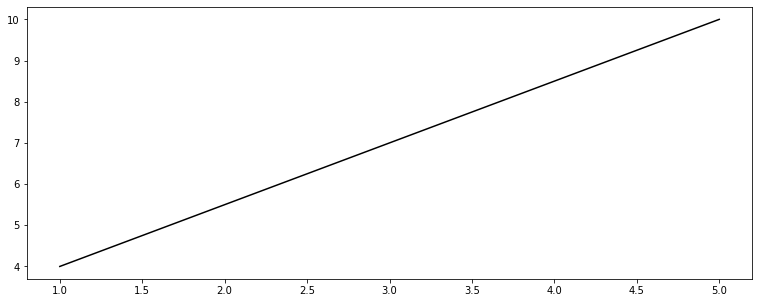

In [23]:
fig,ax = plt.subplots(figsize=(13,5))
ax.plot([1,5], [4,10],'w-',linestyle='-',color='black',zorder=3)

In [32]:
team = 'barcelona'
df = pd.read_csv(f'/work/assets/{team}/{team}_ptype.csv')

In [33]:
df.head(10)

,player,press,switch,intercepted,blocked
0,Frenkie de Jong,86,17,10,8
1,Lionel Messi,100,13,11,20
2,Jordi Alba,41,14,7,21
3,Antoine Griezmann,31,3,0,5
4,Clément Lenglet,41,7,10,2
5,Gerard Piqué,42,15,1,2
6,Sergio Busquets,67,11,5,4
7,Sergi Roberto,45,1,3,14
8,Neto,22,1,0,1
9,Philippe Coutinho,39,3,5,4


In [29]:
# df = df.sort_values('blocked')
# cols = np.repeat(df.columns[1::2],2)
# cols = [col + '_x' if i % 2 == 0 else col + '_y' for i,col in enumerate(cols)]
# cols = np.concatenate([df.columns[:3], cols])
# cols

In [41]:
df
pd.melt(df, id_vars=df.columns[:1], value_vars=df.columns[1:5], var_name='melt')

,player,melt,value
0,Frenkie de Jong,melt,press
1,Lionel Messi,melt,press
2,Jordi Alba,melt,press
3,Antoine Griezmann,melt,press
4,Clément Lenglet,melt,press
...,...,...,...
179,Ronald Araújo,value,1
180,Francisco Trincão,value,10
181,Junior Firpo,value,0
182,Carles Aleñá,value,0


In [45]:
pd.pivot_table(data=df, index='blocked', columns='player')

KeyError: 'blocked'